Imports and preparation

In [86]:
#Imports
import os
from os import listdir
from os.path import isfile, join
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from skimage import measure
from statistics import mean

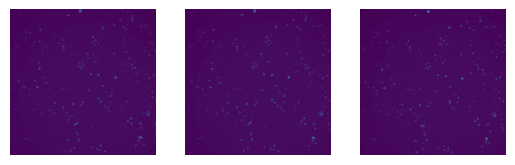

In [87]:
#Import the original images
images_path = str(os.getcwd()) + '\\data_for_cellpose\\'
onlyfiles = [f for f in listdir(images_path) if isfile(join(images_path, f)) and f.endswith('.tiff')]
images = [np.squeeze(tifffile.imread(images_path +  onlyfiles[i])) for i in range(len(onlyfiles))]

for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

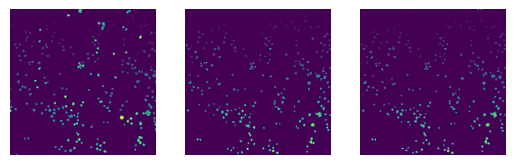

In [88]:
#Import the groundtruth masks
instance_masks_path = str(os.getcwd()) + '\\data_for_cellpose\\'
onlyfiles = [f for f in listdir(images_path) if isfile(join(images_path, f)) and f.endswith('.npy')]
gt_instance_masks = [np.load(instance_masks_path + onlyfiles[i], allow_pickle=True).item()['masks'] for i in range(len(onlyfiles))]
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(gt_instance_masks[i])
    plt.axis('off')
plt.show()

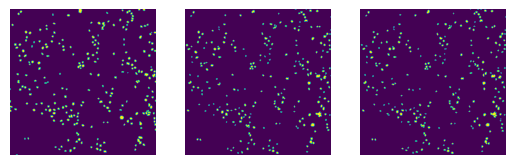

In [89]:
#Binarise the groundtruth masks
binary_gt_instance_masks = [np.where(gt_instance_masks[i] > 0, 1, 0) for i in range(len(gt_instance_masks))]
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(binary_gt_instance_masks[i])
    plt.axis('off')
plt.show()

In [108]:
#Get our instances algorithm
def instance_seg_alg(binary_mask):
    return measure.label(binary_mask, background=0,connectivity=1)

Quantitative analysis

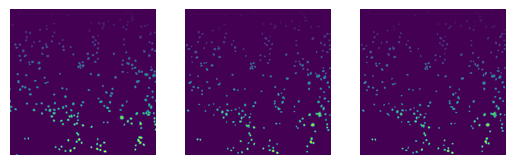

In [109]:
#Get the instance segmentation on the binary masks
instance_masks = [instance_seg_alg(binary_gt_instance_masks[i]) for i in range(len(binary_gt_instance_masks))]
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(instance_masks[i])
    plt.axis('off')
plt.show()

In [110]:
#Get the difference in number of cells found
num_cells = np.array([np.max(instance_masks[i]) for i in range(len(instance_masks))])
num_gt_cells = np.array([np.max(gt_instance_masks[i]) for i in range(len(gt_instance_masks))])
print('Found cells on average compared to the groundtruth',str(round(mean(num_cells/num_gt_cells)*100,2))+'%')

Found cells on average compared to the groundtruth 94.33%


In [93]:
#We now have info to compare which method finds more cell masks, which can be wrong or right
#Conclusion: we find less masks in general than the ground truth one, but very very close to it still

In [94]:
print(len(images))

24


Qualitative analysis

In [95]:
#Get 108x108 crops of the original images (make them smaller if not precise enough)
crop_size = 108
n_crops = images[0].shape[0] // crop_size
image_crops = []
gt_im_crops = []
im_crops = []
for k in range(len(images)):
    for i in range(n_crops):
        for j in range(n_crops):
            image_crop = images[k][i*crop_size:(i+1)*crop_size, j*crop_size:(j+1)*crop_size]
            im_crop = instance_masks[k][i*crop_size:(i+1)*crop_size, j*crop_size:(j+1)*crop_size]
            gt_im_crop = gt_instance_masks[k][i*crop_size:(i+1)*crop_size, j*crop_size:(j+1)*crop_size]
            if len(np.where(im_crop > 0)[0]) < 1500:
                continue

            im_crops.append(im_crop)
            image_crops.append(image_crop)
            gt_im_crops.append(gt_im_crop)
print(len(image_crops),len(im_crops),len(gt_im_crops))
#Select the indexes of crop that look like they have a lot of cells and would be interesting to segment

30 30 30


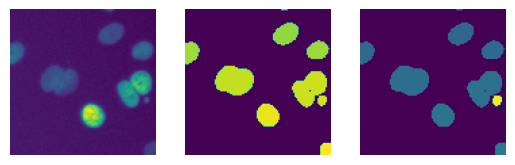

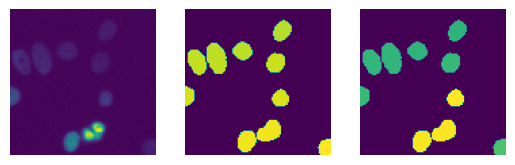

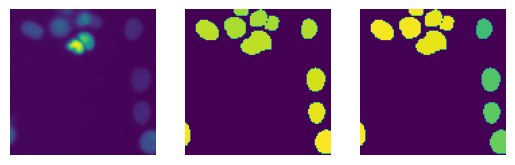

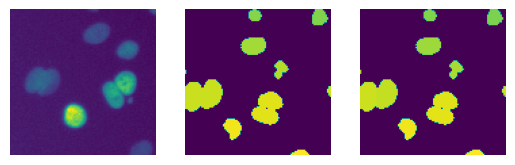

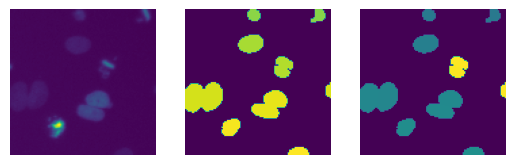

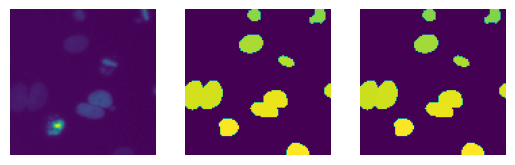

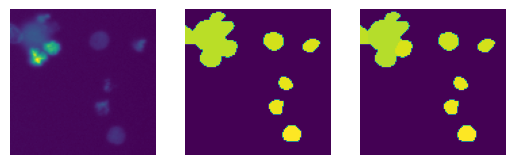

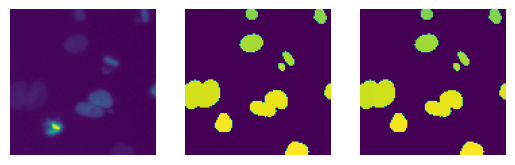

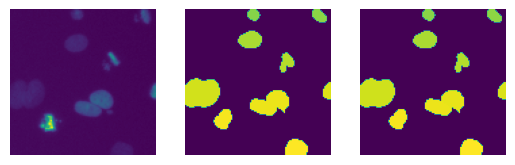

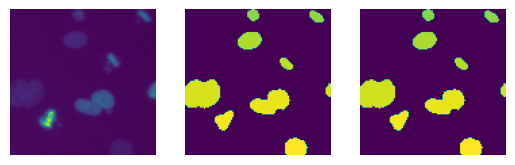

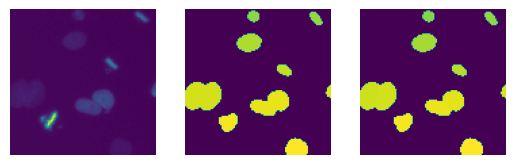

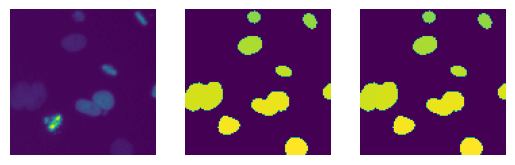

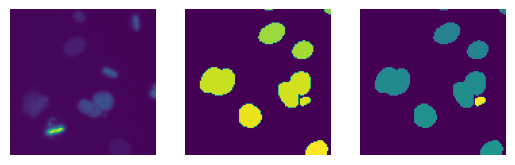

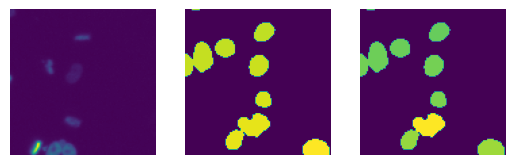

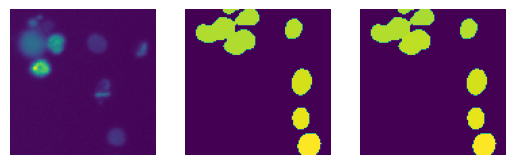

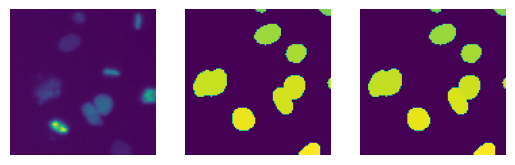

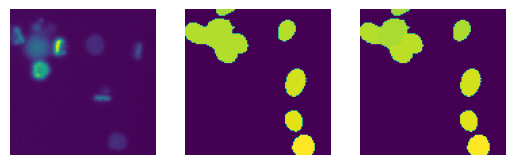

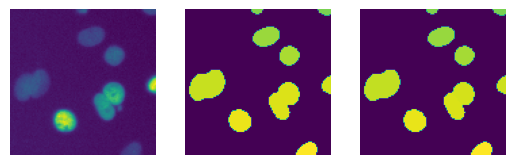

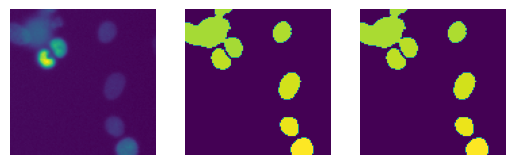

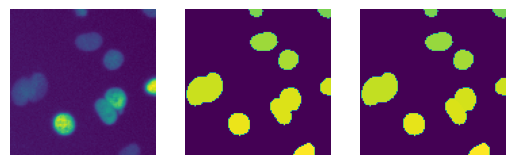

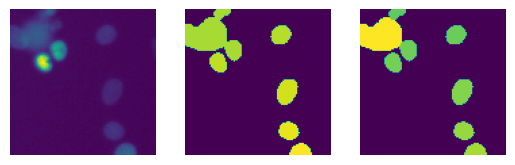

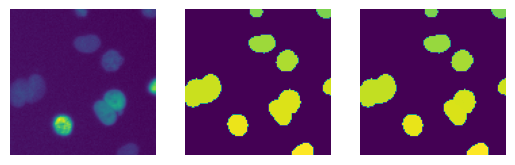

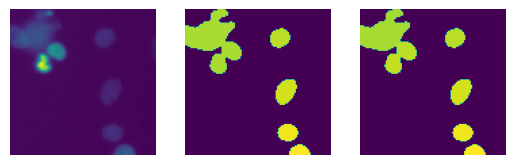

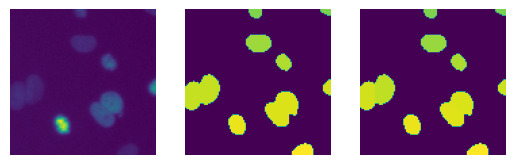

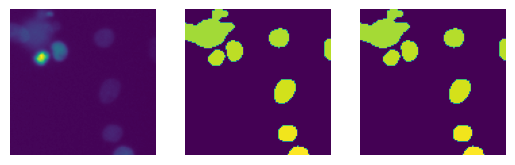

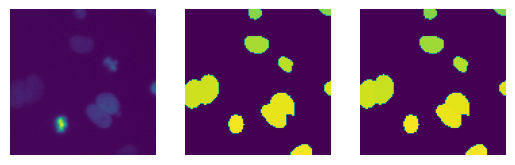

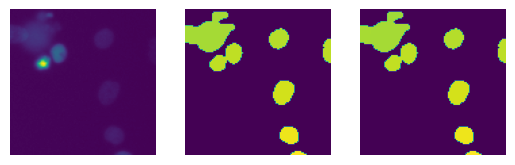

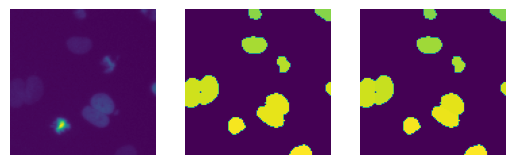

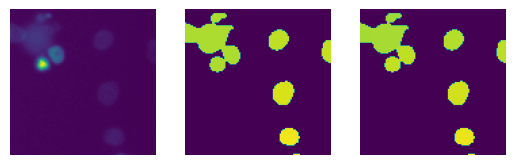

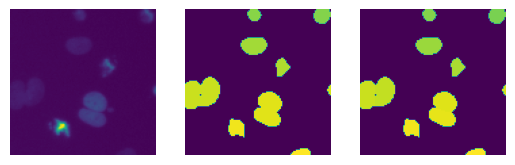

In [99]:
for i in range(len(im_crops)):
    plt.subplot(1,3,1)
    plt.imshow(image_crops[i])
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(im_crops[i       ])
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(gt_im_crops[i])
    plt.axis('off')
    plt.show()

In [12]:
import PySimpleGUI as sg
import numpy as np
import io
from PIL import Image
from io import BytesIO
import PIL

def array_to_data(array):
    im = Image.fromarray(array)
    #new_width = 400
    #new_height = 400
    #scale = min(new_height/108, new_width/108)
    #im = im.resize((int(108*scale), int(108*scale)), PIL.Image.ANTIALIAS)
    with BytesIO() as output:
        im.save(output, format="PNG")
        data = output.getvalue()
    return data




# Define the layout of the GUI
layout = [
    [sg.Image(data='', key='-IMAGE-')],
    [sg.Button('Keep'), sg.Button('Discard')],
    [sg.Text('Kept: 0   Discarded: 0', key='-COUNTER-')]
]

# Create the window
window = sg.Window('Image Viewer', layout, finalize=True)

# Define the lists for keeping and discarding images
keep_list = []
discard_list = []

# Loop over the images
images = image_crops  # replace with your numpy arrays
for image in images:
    # Convert the numpy array to bytes and update the image in the GUI
    #bio = io.BytesIO()
    #np.save(bio, image)
    window['-IMAGE-'].update(data=array_to_data(image))

    # Wait for a button press
    event, values = window.read()

    # Handle the button press
    if event == 'Keep':
        keep_list.append(image)
    elif event == 'Discard':
        discard_list.append(image)

    # Update the counters in the GUI
    window['-COUNTER-'].update('Kept: {}   Discarded: {}'.format(len(keep_list), len(discard_list)))

# Close the window
window.close()

In [96]:
indices = []
for i in range(len(keep_list)):
    for j in range(len(image_crops)):
        print(j)
        if (keep_list[i] == image_crops[j]).all():
            indices.append(j)
            break
print(indices)

0
0
1
0
1
2
0
1
2
3
4
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
[0, 1, 2, 4, 6, 13, 14, 15, 16, 17, 19, 20, 23, 24, 29]


In [97]:
def equidistant_list(input_list):
    # Sort the input list in ascending order
    sorted_list = sorted(input_list)

    # Calculate the minimum and maximum values in the input list
    min_val = sorted_list[0]
    max_val = sorted_list[-1]

    # If all values in the input list are the same, return a list of zeros
    if min_val == max_val:
        return [0] * len(input_list)

    # Calculate the distance between adjacent values in the sorted list
    distance = (max_val - min_val) / (len(input_list) - 1)

    # Generate the output list by spacing out the values as far as possible
    output_list = []
    current_val = min_val
    for i in range(len(input_list)):
        output_list.append(int(round((current_val - min_val) / (max_val - min_val) * 255)))
        current_val += distance

    return output_list

0


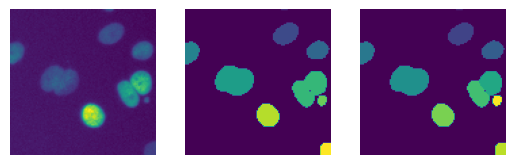

1


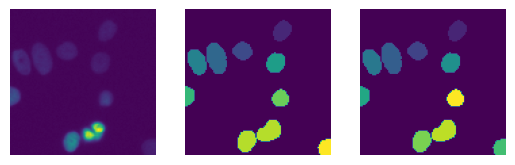

2


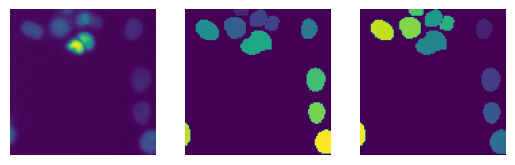

4


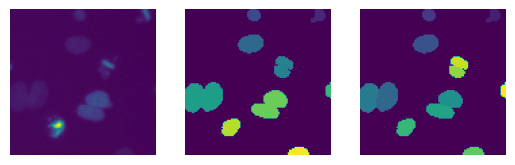

6


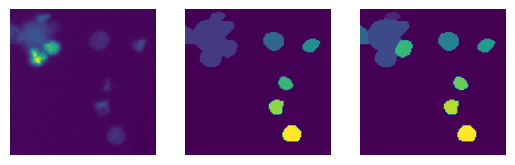

13


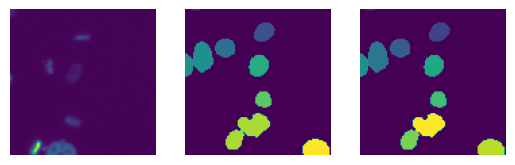

14


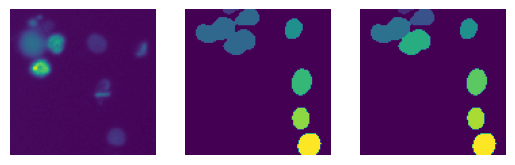

15


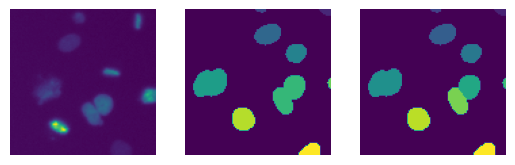

16


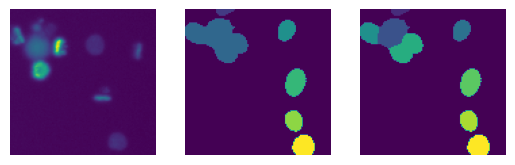

17


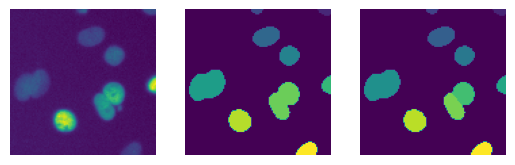

19


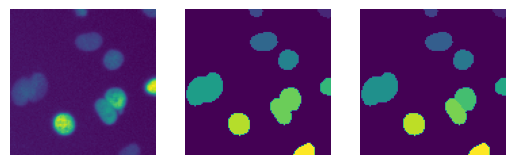

20


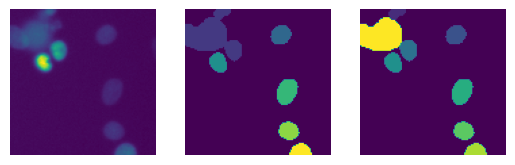

23


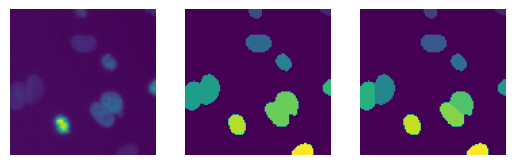

24


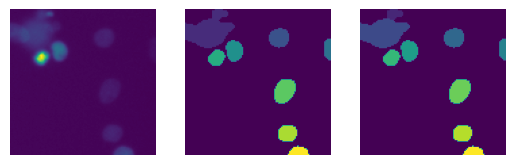

29


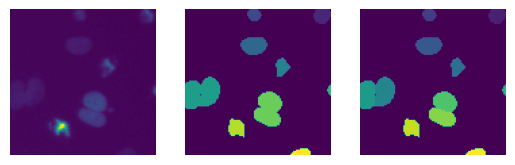

In [102]:
for i in indices:
    print(i)
    plt.subplot(1,3,1)
    plt.imshow(image_crops[i])
    plt.axis('off')


    plt.subplot(1,3,2)
    input = np.unique(im_crops[i])
    output = equidistant_list(np.unique(im_crops[i]))
    new_img = im_crops[i].copy()
    for j in range(len(output)):
        new_img = np.where(new_img == input[j], output[j], new_img)
    plt.imshow(new_img)
    plt.axis('off')


    plt.subplot(1,3,3)
    input = np.unique(gt_im_crops[i])
    output = equidistant_list(np.unique(gt_im_crops[i]))
    new_img = gt_im_crops[i].copy()
    for j in range(len(output)):
        new_img = np.where(new_img == input[j], output[j], new_img)
    plt.imshow(new_img)
    plt.axis('off')

    plt.show()


9


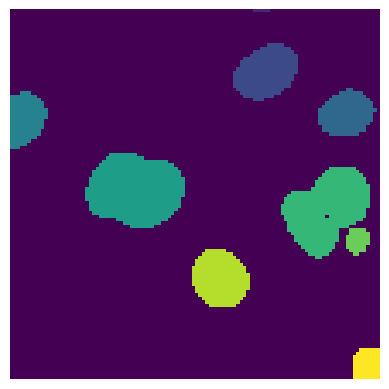

10


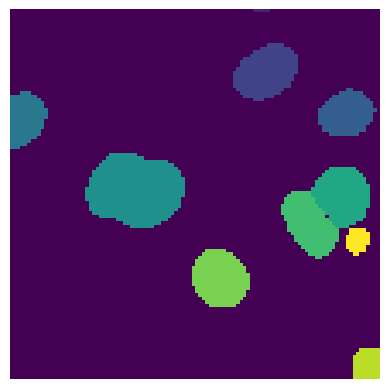

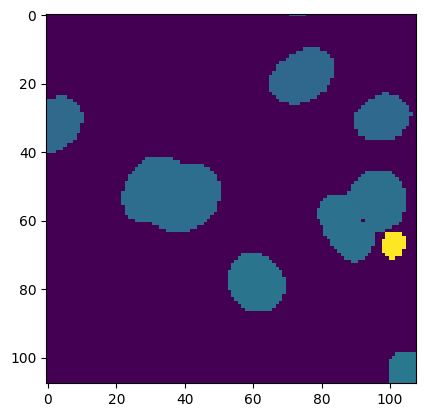

()


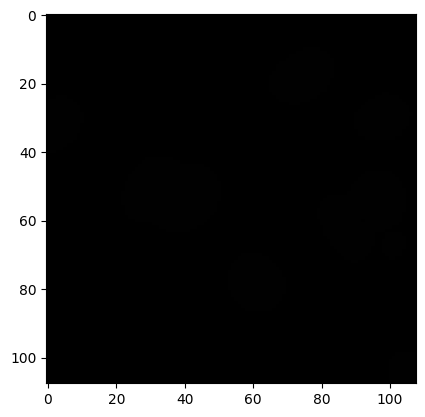

In [184]:
import cv2

import numpy as np
from scipy.ndimage import label
import matplotlib.pyplot as plt


print(len(np.unique(im_crops[0]))-1)
input = np.unique(im_crops[0])
output = equidistant_list(np.unique(im_crops[0]))
new_img = im_crops[0].copy()
for j in range(len(output)):
    new_img = np.where(new_img == input[j], output[j], new_img)
plt.imshow(new_img)
plt.axis('off')
plt.show()

print(len(np.unique(gt_im_crops[0]))-1)
input = np.unique(gt_im_crops[0])
output = equidistant_list(np.unique(gt_im_crops[0]))
new_img = gt_im_crops[0].copy()
for j in range(len(output)):
    new_img = np.where(new_img == input[j], output[j], new_img)
plt.imshow(new_img)
plt.axis('off')
plt.show()

params = cv2.SimpleBlobDetector_Params()
params.filterByCircularity = True
params.minCircularity = 0.001
params.filterByInertia = True
params.minInertiaRatio = 0.001
params.filterByArea = True
params.minArea = 1
ver = (cv2.__version__).split('.')
if int(ver[0]) < 3 :
  detector = cv2.SimpleBlobDetector(params)
else : 
  detector = cv2.SimpleBlobDetector_create(params)
binary_mask = np.where(gt_im_crops[0] > 0, 1, 0).astype(np.uint8)
Gaussian = cv2.GaussianBlur(binary_mask, (21, 21), 0)
plt.imshow(gt_im_crops[0])
plt.show()
#inverted_img = cv2.bitwise_not(Gaussian)
keypoints = detector.detect(Gaussian.astype(np.uint8))
print(keypoints)
im_with_keypoints = cv2.drawKeypoints(binary_mask, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(im_with_keypoints)
plt.show()

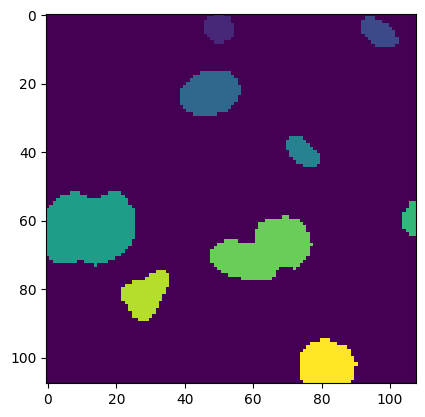

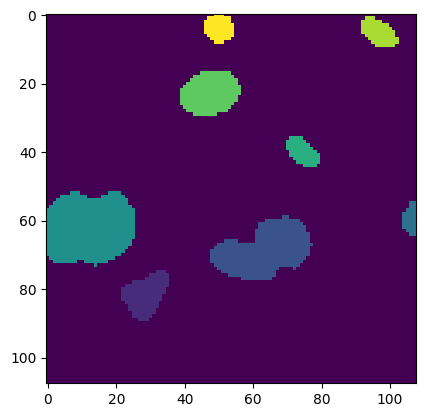

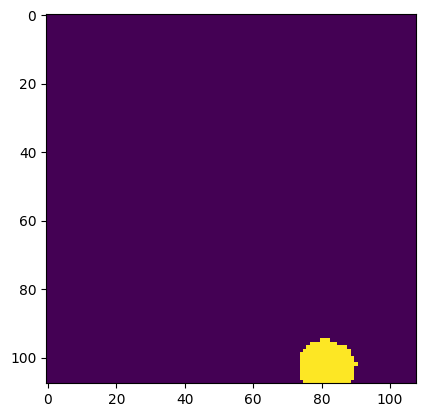

In [78]:
new_img_8bit = np.uint8(new_img * 255)
binarized = np.where(new_img_8bit == np.unique(new_img_8bit)[1], 255, 0).astype(np.uint8)
#print(np.unique(binarized))
contours, hierarchy = cv2.findContours(binarized, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

new_img_cont = new_img_8bit.copy()
new_img_cont = cv2.drawContours(new_img_cont, contours, -1, (0,10,0), 10)

plt.imshow(new_img)
plt.show()
plt.imshow(new_img_cont)
plt.show()
plt.imshow(binarized)
plt.show()
#print(contours)

#print(new_img_8bit.dtype)

In [53]:
np.unique(new_img)[0]

0

In [54]:
cnts = cv2.findContours(np.where(new_img==np.unique(new_img)[0],1,0), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\contours.cpp:197: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'


0
0
1
0
1
2
0
1
2
3
4
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
[0, 1, 2, 4, 6, 13, 14, 15, 16, 17, 19, 20, 23, 24, 29]


In [ ]:
print(np.unique(keep_list[0))

In [ ]:
#Put the crops we selected through our instance algorithm

In [ ]:
#Display the original image crop, the instance segmentation we made and the groundtruth mask

In [ ]:
#We now have info to compare which method makes the "better" cell instances